In [1]:
import numpy as np
import pandas as pd

In [2]:
df_train = pd.read_csv('C:/Users/Ax/Desktop/w+c/train.csv', encoding='utf-8')
df_train['id'] = df_train['id'].apply(str)

In [3]:
df_test = pd.read_csv('C:/Users/Ax/Desktop/w+c/test.csv', encoding='utf-8')
df_test['test_id'] = df_test['test_id'].apply(str)

In [4]:
df_all = pd.concat((df_train, df_test),sort=True)
df_all['question1'].fillna('', inplace=True)
df_all['question2'].fillna('', inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import itertools

In [6]:
counts_vectorizer = CountVectorizer(max_features=10000-1).fit(
    itertools.chain(df_all['question1'], df_all['question2']))
other_index = len(counts_vectorizer.vocabulary_)

In [7]:
import re
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
words_tokenizer = re.compile(counts_vectorizer.token_pattern)

In [9]:
def create_padded_seqs(texts, max_len=30):
    seqs = texts.apply(lambda s: 
        [counts_vectorizer.vocabulary_[w] if w in counts_vectorizer.vocabulary_ else other_index
         for w in words_tokenizer.findall(s.lower())])
    return pad_sequences(seqs, maxlen=max_len)

In [10]:
#df_all = df_all.sample(1000) # Just for debugging

In [40]:
X1_train, X1_val, X2_train, X2_val, y_train, y_val = \
    train_test_split(create_padded_seqs(df_all[df_all['id'].notnull()]['question1']), 
                     create_padded_seqs(df_all[df_all['id'].notnull()]['question2']),
                     df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     stratify=df_all[df_all['id'].notnull()]['is_duplicate'].values,
                     test_size=0.1)

In [41]:
import keras.layers as lyr
from keras.models import Model

In [63]:
input1_tensor = lyr.Input(X1_train.shape[1:])
input2_tensor = lyr.Input(X2_train.shape[1:])

words_embedding_layer = lyr.Embedding(X1_train.max() + 1, 300)
seq_embedding_layer = lyr.LSTM(256, activation='tanh')

seq_embedding = lambda tensor: seq_embedding_layer(words_embedding_layer(tensor))

merge_layer = lyr.multiply([seq_embedding(input1_tensor), seq_embedding(input2_tensor)])

dense1_layer = lyr.Dense(16, activation='sigmoid')(merge_layer)

ouput_layer = lyr.Dense(1, activation='sigmoid')(dense1_layer)

model = Model([input1_tensor, input2_tensor], ouput_layer)

model.compile(loss='mae', optimizer='adam')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 30, 300)      3000000     input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 256)          570368      embedding_3[0][0]                
          

In [92]:
model.fit([X1_train, X2_train], y_train, 
          validation_data=([X1_val, X2_val], y_val), 
          batch_size=64, epochs=50, verbose=2)

Train on 228947 samples, validate on 25439 samples
Epoch 1/50
 - 241s - loss: 0.1318 - val_loss: 0.1525
Epoch 2/50
 - 242s - loss: 0.1292 - val_loss: 0.1485
Epoch 3/50
 - 241s - loss: 0.1272 - val_loss: 0.1477
Epoch 4/50
 - 242s - loss: 0.1239 - val_loss: 0.1482
Epoch 5/50
 - 241s - loss: 0.1213 - val_loss: 0.1437
Epoch 6/50
 - 243s - loss: 0.1193 - val_loss: 0.1427
Epoch 7/50
 - 241s - loss: 0.1160 - val_loss: 0.1393
Epoch 8/50
 - 245s - loss: 0.1148 - val_loss: 0.1413
Epoch 9/50
 - 244s - loss: 0.1118 - val_loss: 0.1401
Epoch 10/50
 - 242s - loss: 0.1101 - val_loss: 0.1379
Epoch 11/50
 - 243s - loss: 0.1071 - val_loss: 0.1381
Epoch 12/50
 - 245s - loss: 0.1065 - val_loss: 0.1356
Epoch 13/50
 - 240s - loss: 0.1057 - val_loss: 0.1357
Epoch 14/50
 - 240s - loss: 0.1038 - val_loss: 0.1356
Epoch 15/50
 - 241s - loss: 0.1036 - val_loss: 0.1335
Epoch 16/50
 - 241s - loss: 0.1024 - val_loss: 0.1327
Epoch 17/50
 - 240s - loss: 0.1012 - val_loss: 0.1319
Epoch 18/50
 - 243s - loss: 0.0996 - val

In [93]:
features_model = Model([input1_tensor, input2_tensor], merge_layer)
features_model.compile(loss='mse', optimizer='adam')

In [94]:
F_train = features_model.predict([X1_train, X2_train], batch_size=64)
F_val = features_model.predict([X1_val, X2_val], batch_size=64)

In [95]:
import xgboost as xgb

In [96]:
dTrain = xgb.DMatrix(F_train, label=y_train)
dVal = xgb.DMatrix(F_val, label=y_val)

In [97]:
xgb_params = {
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'eval_metric': 'logloss',
    'eta': 0.1, 
    'max_depth': 9,
    'subsample': 0.9,
    'colsample_bytree': 1 / F_train.shape[1]**0.5,
    'min_child_weight': 5,
    'silent': 1
}
bst = xgb.train(xgb_params, dTrain, 1000,  [(dTrain,'train'), (dVal,'val')], 
                verbose_eval=10, early_stopping_rounds=10)

[0]	train-logloss:0.663084	val-logloss:0.664789
Multiple eval metrics have been passed: 'val-logloss' will be used for early stopping.

Will train until val-logloss hasn't improved in 10 rounds.
[10]	train-logloss:0.483338	val-logloss:0.499586
[20]	train-logloss:0.398336	val-logloss:0.425103
[30]	train-logloss:0.354167	val-logloss:0.390077
[40]	train-logloss:0.325369	val-logloss:0.368962
[50]	train-logloss:0.3013	val-logloss:0.351457
[60]	train-logloss:0.285441	val-logloss:0.341443
[70]	train-logloss:0.270521	val-logloss:0.331945
[80]	train-logloss:0.260629	val-logloss:0.327028
[90]	train-logloss:0.252897	val-logloss:0.323291
[100]	train-logloss:0.244436	val-logloss:0.319482
[110]	train-logloss:0.237146	val-logloss:0.316682
[120]	train-logloss:0.230382	val-logloss:0.31428
[130]	train-logloss:0.225529	val-logloss:0.31287
[140]	train-logloss:0.220674	val-logloss:0.310984
[150]	train-logloss:0.216543	val-logloss:0.309383
[160]	train-logloss:0.212714	val-logloss:0.30831
[170]	train-logloss

In [98]:
X1_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question1'])
X2_test = create_padded_seqs(df_all[df_all['test_id'].notnull()]['question2'])

In [99]:
F_test = features_model.predict([X1_test, X2_test], batch_size=64)

In [100]:
dTest = xgb.DMatrix(F_test)

In [101]:
df_sub = pd.DataFrame({
        'test_id': df_all[df_all['test_id'].notnull()]['test_id'].values,
        'y_pre': bst.predict(dTest, ntree_limit=bst.best_ntree_limit)
    }).set_index('test_id')

In [102]:
df_sub.head()

,y_pre
test_id,
0,0.410701
1,0.907897
2,0.102319
3,0.974736
4,0.080133


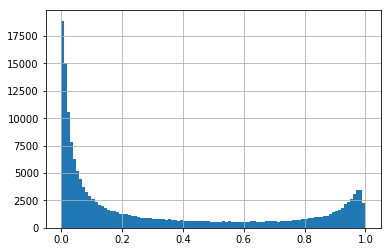

In [103]:
df_sub['y_pre'].hist(bins=100)

In [104]:
df_sub.to_csv('submission20180624LSTM_w+c_11.csv', index=False)